In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [2]:
max_iterations = 1000
warnings.filterwarnings('ignore')

# Load the datasets
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')


In [3]:
# Split features and labels
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']


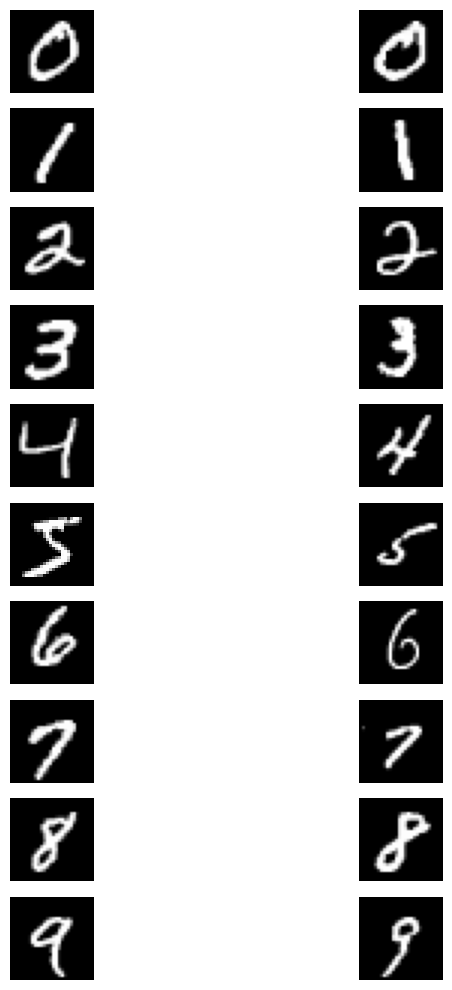

In [4]:


# Function to visualize two images of each class
def visualize_images(X, y, num_images=2):
    fig, axs = plt.subplots(10, num_images, figsize=(10, 10))
    for i in range(10):
        indices = np.where(y == i)[0][:num_images]
        for j, idx in enumerate(indices):
            axs[i, j].imshow(X.iloc[idx].values.reshape(28, 28), cmap='gray')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize two images of each class
visualize_images(X_train, y_train)


In [5]:
# Binary logistic regression for one-versus-one (OVO) classification
ovo_models = {}
for i in range(10):
    for j in range(i+1, 10):
        # Select samples for classes i and j
        X_ovo = X_train[(y_train == i) | (y_train == j)]
        y_ovo = y_train[(y_train == i) | (y_train == j)]
        y_ovo = np.where(y_ovo == i, 0, 1)  # Label as 0 for class i and 1 for class j

        # Train logistic regression model
        model = LogisticRegression(max_iter=max_iterations)
        model.fit(X_ovo, y_ovo)
        ovo_models[(i, j)] = model


In [6]:
# Binary logistic regression for one-versus-rest (OVR) classification
ovr_models = {}
for i in range(10):
    y_ovr = np.where(y_train == i, 1, 0)  # Label as 1 for class i and 0 for rest

    # Train logistic regression model
    model = LogisticRegression(max_iter=max_iterations)
    model.fit(X_train, y_ovr)
    ovr_models[i] = model


In [7]:
# Perform PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


In [8]:
# Percentage of variance covered by the first two principal components
variance_ratio = sum(pca.explained_variance_ratio_) * 100
print("Variance covered by the first two principal components: {:.2f}%".format(variance_ratio))

Variance covered by the first two principal components: 16.80%


In [9]:
# Evaluate OVO classification
def evaluate_ovo(models, X_test, y_test):
    if len(X_test) == 0:
        print("Error: Empty test set")
        return
    y_pred_ovo = np.zeros(len(y_test))
    for i in range(10):
        for j in range(i+1, 10):
            idx = np.where((y_pred_ovo == 0) & ((y_test == i) | (y_test == j)))[0]
            X_ovo = X_test.iloc[idx]
            if len(X_ovo) > 0:
                y_pred = models[(i, j)].predict(X_ovo)
                y_pred_ovo[idx] = np.where(y_pred == 0, i, j)
    print("OVO Classification Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_ovo))
    print("Precision:", precision_score(y_test, y_pred_ovo, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred_ovo, average='weighted'))
    print("F1-score:", f1_score(y_test, y_pred_ovo, average='weighted'))



In [10]:
# Evaluate OVR classification
def evaluate_ovr(models, X_test, y_test):
    if len(X_test) == 0:
        print("Error: Empty test set")
        return
    y_pred_ovr = np.zeros(len(y_test))
    for i in range(10):
        y_pred = models[i].predict(X_test)
        y_pred_ovr[y_pred == 1] = i
    print("OVR Classification Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_ovr))
    print("Precision:", precision_score(y_test, y_pred_ovr, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred_ovr, average='weighted'))
    print("F1-score:", f1_score(y_test, y_pred_ovr, average='weighted'))


In [11]:

# Evaluate both approaches
print("---------------------------------------------")
evaluate_ovo(ovo_models, X_test, y_test)
print("---------------------------------------------")
evaluate_ovr(ovr_models, X_test, y_test)
print("---------------------------------------------")


---------------------------------------------
OVO Classification Metrics:
Accuracy: 0.996
Precision: 0.9960274353429924
Recall: 0.996
F1-score: 0.9959713879004314
---------------------------------------------
OVR Classification Metrics:
Accuracy: 0.8433
Precision: 0.8777859162101153
Recall: 0.8433
F1-score: 0.8514726966205333
---------------------------------------------


In [13]:
print("Metrics shows OVO is better.")

Metrics shows OVO is better.
